In [2]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [3]:
function kalman_filter_graph()
    model = Model(DefaultMessageGate())
    
    x_prev = add!(model, datavar(:x_prior, Normal{Float64}))
    add_1  = add!(model, constvar(:add_1, 1.0))
    x      = add!(model, randomvar(:x))
    
    x_prev_add = add!(model, make_node(+, x, add_1, x_prev))
    
    noise = add!(model, constvar(:noise, Normal(0.0, sqrt(200.0))))
    y     = add!(model, datavar(:y, Dirac{Float64}))
    
    add_x_and_noise = add!(model, make_node(+, y, x, noise))
    
    activate!(model)
    
    return x_prev, x, y
end

function kalman(data)
    N = length(data)
    
    x_prev, x, y = kalman_filter_graph()

    link(x_prev, getmarginal(x))
    
    update!(x_prev, Normal(0.0, sqrt(10000.0)))
    
    marginals = Vector{Normal{Float64}}(undef, N)
    
    subscribe!(getmarginal(x) |> enumerate(), (t) -> marginals[t[1]] = getdata(t[2]))
    
    for d in data
        update!(y, d)
    end
    
    return marginals
end

kalman (generic function with 1 method)

In [4]:
N = 600
data = collect(1:N) + sqrt(200.0) * randn(N);

In [5]:
@time kalman(data); # Initial compilation

  2.591756 seconds (7.36 M allocations: 395.724 MiB, 4.10% gc time)


In [14]:
@time kalman(data); # Subsequent runs

  0.000943 seconds (15.55 k allocations: 616.391 KiB)


In [15]:
@btime kalman($data); # Performance benchmark

  568.883 μs (15553 allocations: 616.39 KiB)


In [7]:
using Plots

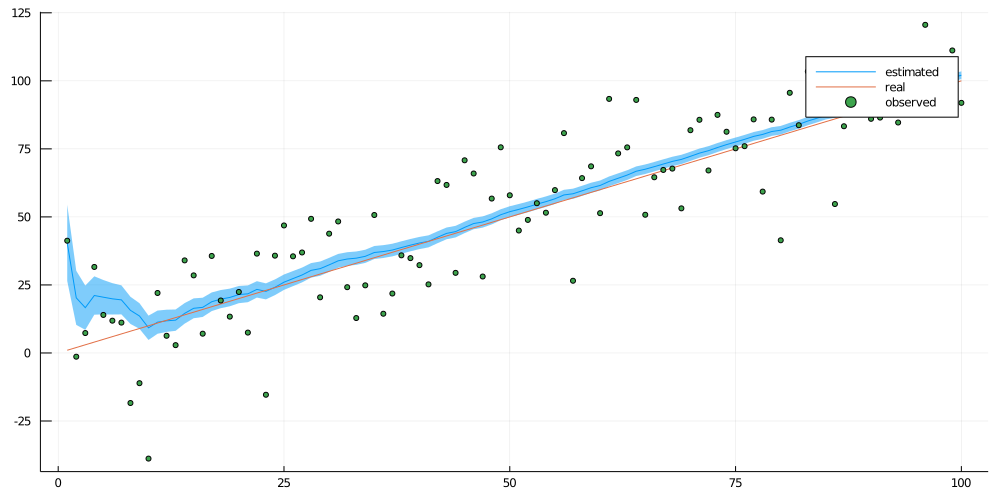

In [8]:
real_data = collect(1:100)
obs_data  = real_data .+ (sqrt(200.0) * randn(100));
estimated = kalman(obs_data)

graph = plot(mean.(estimated), ribbon = std.(estimated), label = :estimated)
graph = plot!(graph, real_data, label = :real)
graph = scatter!(graph, obs_data, ms = 3, label = :observed)

plot(graph, size = (1000, 500))